# Energy calculation for flares in K2 lightcurves
## To Do:
- ~~retrieve colors~~
- ~~retrieve distances for cluster~~
- ~~from colors estimate spectral class~~
- from spectral class use spectrum from Sarah's SpecPhot
- from spectral class use radius from XXX
- use Kepler filter curve to calculate quiescent flux:
- L_∗ = πR^2 ∗int( dλ R_Kepler(λ)* B_SpecPhot(λ))
- Finally: ED*L_*=Kepler energy

In [169]:
#if band value == -999.0 no magnitude is given
#read in table for spectral class: read in as list [class,lum_class,u-g,g-r,r-i,i-z,z-J,J-H,H-k,Jmag_abs]
#LATER: Add z-y from mamajek or so...
import numpy as np
spec_class,lum_class,ug,gr,ri,iz,zJ,JH,HK,Jmag_abs=np.loadtxt('share/cross_match/union/spectralclasses_padded.csv',skiprows=49,delimiter=',',unpack=True,dtype=[('spec_class','S4'),('lum_class','U3'),('u-g',np.float),('g-r',np.float),('r-i',np.float),('i-z',np.float),('z-J',np.float),('J-H',np.float),('H-K',np.float),('Jmag_abs',np.float)])
spec_class=[x.strip(' ') for x in spec_class]
lum_class=[x.strip(' ') for x in lum_class]
lum_class_I=[i for i,x in enumerate(lum_class) if x=='I']
lum_class_III=[i for i,x in enumerate(lum_class) if x=='III']
lum_class_V=[i for i,x in enumerate(lum_class) if x=='V']
print(lum_class_I)
spec_class_I=[x for i,x in enumerate(spec_class) if i in lum_class_I]
spec_class_III=[x for i,x in enumerate(spec_class) if i in lum_class_III]
spec_class_V=[x for i,x in enumerate(spec_class) if i in lum_class_V]
lookup_spec={'Jmag_abs':Jmag_abs,'V':lum_class_V,'III':lum_class_III,'I':lum_class_I,'class':spec_class,'ug':ug,'gr':gr,'ri':ri,'iz':iz,'zJ':zJ,'jh':JH,'hk':HK}
#calculate distance modulus for cluster
DM = lambda x: 5.*np.log10(float(x))-5. 
dm=DM(basics[3])
global dm

[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]


In [211]:
def find_spec_class(lookup_spec,color, index,l='V'):
    try:
        spec_class=lookup_spec['class']
        lum_class=lookup_spec[l]

        color_list=lookup_spec[index]
        i_lam=min(color_list, key=lambda x:abs(x-color))
        idx=search(color_list,lum_class,color)
        if len(idx)!=0:
            spec_classes=[spec_class[j] for j in idx]

        else:
            spec_classes='color too high or low to be assigned to spectral class in this luminosity class'
        return idx,[spec_classes,l]
    except KeyError:
        idx=[]
        return idx,'no entries for this color index'
    
def search(l,id_, val):
    
    results=[]
    l=list(l)
    id_=list(id_)
    l=list(l)
    l1=[(x,l[x]) for x in id_]

    l2=l1[1:]+[(id_[-1]+1,-l1[-2][1]+2.*l1[-1][1])]
    #print('{}\n{}\n{}'.format(l,l1,id_))
    #print(l1,l2)
    for i,j in zip(l1,l2):
        if i[1]<val<j[1]:
            if (val-i[1] > val-j[1]): 
                results.append(i[0])
            else:
                if (j==l2[-1][1]):
                    results.append(i[0])
                else:
                    results.append(j[0])
    #print(results)
    #print('{}\n{}'.format(results,id_))

    return results
            

In [212]:
import random

def dprint(str,debug):
    if debug==True:
        print(str)
    return

def display(opt,d,debug):
    dprint('New combination: {}'.format(opt),debug)
    dprint('This combination has distance {}'.format(d),debug)
    return
           
def insert_spec_class(c,lookup_spec,c1,c2,index,l='V'):
    if c1!=-999.0 and c2!=-999.0:
        idx,all_spectral_classes=find_spec_class(lookup_spec,c1-c2,index,l)
        c[index]=[c1-c2,all_spectral_classes]
    else:
        idx=[]
    return idx

def insert_lum_class(c,lookup_spec,J,index,l='V'):
    if J!=-999.0:
        J-=dm
        idx, all_spectral_classes=find_spec_class(lookup_spec,J,'Jmag_abs',l)
        c[index]=[J,all_spectral_classes]
    else:
        idx=[]
    return idx

def optimize_spec_class(obj_handle,colors,lookup_spec,c_idx='jhkJ',debug=False):
    
    #Depending on the catalog from the colors are constructed either JHK or grizy is available:
    color_indices={'jhkJ':{'jh':colors[:2],'hk':colors[1:3],'J':colors[3]},'grizyJ':{'gr':colors[:2],'ri':colors[1:3],'iz':colors[2:4],'zy':colors[3:5]}}#,'J':colors[5]
    #Different luminosity classes can occur
    luminosity_classes={'I':0.01,'III':0.,'V':-0.01}
    
    #Now choose a set of colors: jhkJ or grizyJ
    indices=color_indices[c_idx]
    
    #Initialize the procedure:
    lum_opt=dict()
    minspread=10000
    best_lum_class='V'
    best_spec_class='None'
    opt_backup=dict()
    
    #Construct the optimum spec class solution for each luminosity class:
    for lum_class, weight in luminosity_classes.items():
        dprint('-------------',debug)
        dprint(lum_class,debug)
        
        #initialize a list that contain the indices in order to compute the uncertainty on the estimate later
        spr=[]
        #initialize the color indices that are used in the end and their respective values
        color_results={}
        
        #Iterate over all color indices (j,h,k or g,r,i,z,y) to compute possible colors (e.g.: j-h or r-i)
        #This yields a list of possible spectral classes for each color since colors are not 
        #an unambiguous function of spectral class, i.e. several spectral classes can share the same color index
        for key,value in indices.items():
            
            if key=='J':
                #Same goes for luminosity only. Jmag_abs values correspond to spectral classes, too:
                #idx returns the indices into the Pickles'98 table that correspond to spec classes:
                #all of this for the given luminosity class
                idx=insert_lum_class(obj_handle,lookup_spec,value,key,l=lum_class)
            else:
                #unpack the colors for each color index
                c1,c2=value
                #idx returns the indices into the Pickles'98 table that correspond to spec classes:
                #all of this for the given luminosity class
                idx=insert_spec_class(obj_handle,lookup_spec,c1,c2,key,l=lum_class)
 
            #So, for a certain color index name (key) there is a list of indices (idx) that fit into the Pickles'98 table
            color_results[key]=idx
        
        
        dprint(color_results,debug)
        
        #Now given a dict with different colors and possible spec classes for each of them we have to find the best combination
        #This is done by finding the combination which lies closest together within the table and hence has the least uncertainty
        
        #Initialize the a new possible optimum, that may later become the backup solution
        opt=dict()
        #Iterate over all colors and their possible classes to find the closest entries in the other color indices
        for key, value in color_results.items():
            #remove the regarded color index to avoid redundance
            rest_results=dict(color_results)
            del rest_results[key]
            #Iterate over all possible classes (index) for the given central color (key)
            for index in value:
                #add the associated color for the central index
                opt[key]=lookup_spec['class'][index]
                #add central index to the list of indices that should be clostest to each other among all given indices across all colors
                spr.append(index)
                #Init distance list for linear distances
                d=[]
                #Iterate over all other colors and find the indices of possible spectral classes that are closest to the chosen cetral one
                for key2, value2 in rest_results.items():
                    #compute all the linear distances
                    delta=[abs(x-index) for x in value2]
                    if delta!=[]:
                        #find the minimum linear distance
                        dadd=min(delta)
                        d.append(dadd)
                        #find its corresponding index in Pickles'98 table
                        minind=value2[delta.index(dadd)]
                        #add the associated color
                        opt[key2]=lookup_spec['class'][minind]
                        #add to the list of indices that should be closest to each other
                        spr.append(minind)
                
                #distance calculation
                #The row number distance within a padded table is used as proxy to uncertainty
                #distance d is defined as the sum of distances to one of the rows in n-colored space
                d=np.sqrt(sum([x*x for x in d]))/len(color_results)
                
                #select this iteration if it yields a minimum in distance
                try:
                    if d<mindist:
                        #output for debugging
                        display(opt,d,debug)
                        mindist=d
                        opt_backup=dict(opt)
                    else:
                        #output for debugging
                        display(opt,d,debug)
                        dprint('Best solution has been found already, namely: {}'.format(opt_backup),debug)
                        opt.clear()
                #This error occurs if mindist has not yet been assigned
                except UnboundLocalError:
                    #output for debugging
                    display(opt,d,debug)
                    mindist=d
                    opt_backup=dict(opt)
        mindist=0
        del mindist
        #Assign a relative spread within the best solution weighted by the number of colors
        rel_spread=np.std(np.array(spr))/len(spr)
        #Calculate the mean index for the resulting spectral class
        mean=np.mean(np.array(spr))
        dprint('The relative spread for the optimum solution in this luminosity class is {}'.format(rel_spread),debug)
        #Minimize the spread across all luminosity classes
        try:
            if rel_spread+weight<minspread:
                minspread=rel_spread
                best_lum_class=lum_class
                best_spec_class=lookup_spec['class'][int(np.rint(mean))]
        #This error occurs if rel_spread has not yet been assigned
        except UnboundLocalError:
            minspread=rel_spread
            best_lum_class=lum_class
            best_spec_class=lookup_spec['class'][int(np.rint(mean))]
        #Summarize the results for all luminosity classes in one dict:
        lum_opt[lum_class]=[rel_spread,opt_backup]
        
    dprint('-------------------',debug)
    dprint('Best results for spectral class and luminosity class: L={} and spec={}.'.format(best_lum_class,best_spec_class),debug)
    dprint('',debug)
    
    
    return best_lum_class,best_spec_class,lum_opt



## Here I test the pipeline for a single LC in Ruprecht 147, ID=219561713:

In [213]:
try:
    ID,c_idx,colors,results=param_dict[219561713]
except ValueError:
    value=param_dict[219630699]
    ID,c_idx, colors=value
    results=value.append(dict())

optimize_spec_class(results,colors,lookup_spec,c_idx=c_idx,debug=True)

-------------
I
{'hk': [87, 93, 96], 'J': [], 'jh': [79]}
New combination: {'hk': 'F5', 'jh': 'B8'}
This combination has distance 2.66666666667
New combination: {'hk': 'G2', 'jh': 'B8'}
This combination has distance 4.66666666667
Best solution has been found already, namely: {'hk': 'F5', 'jh': 'B8'}
New combination: {'hk': 'G8', 'jh': 'B8'}
This combination has distance 5.66666666667
Best solution has been found already, namely: {'hk': 'F5', 'jh': 'B8'}
New combination: {'hk': 'F5', 'jh': 'B8'}
This combination has distance 2.66666666667
Best solution has been found already, namely: {'hk': 'F5', 'jh': 'B8'}
The relative spread for the optimum solution in this luminosity class is 0.811146709526
-------------
III
{'hk': [51, 54], 'J': [48], 'jh': [41, 44]}
New combination: {'hk': 'K0', 'J': 'G0', 'jh': 'A7'}
This combination has distance 2.53859103529
New combination: {'hk': 'K2', 'J': 'G0', 'jh': 'A7'}
This combination has distance 3.88730126323
Best solution has been found already, nam

('III',
 'G0',
 {'I': [0.81114670952608814, {'hk': 'F5', 'jh': 'B8'}],
  'III': [0.23306863292670035, {'J': 'G0', 'hk': 'K0', 'jh': 'A7'}],
  'V': [0.38796716164969236, {'J': 'A0', 'hk': 'G8', 'jh': 'F2'}]})

## If the test works, try to process the entire cluster with the function defined below

In [214]:
def optimize_spec_class_all(param_dict, lookup_spec, debug=False):
    ID_lum_spec=[]
    for key,value in param_dict.items():
        #print(key)
        try:
            ID,c_idx,colors,results=value
        except ValueError:
            ID,c_idx, colors=value
            value.append(dict())
            results=value[3]

        best_lum_class,best_spec_class,lum_opt=optimize_spec_class(results,colors,lookup_spec,c_idx=c_idx,debug=debug)
        ID_lum_spec.append((key,best_lum_class,best_spec_class))
    return ID_lum_spec

In [215]:
import numpy as np
cluster='Ruprecht_147'
params=open('share/cross_match/union/'+cluster+'_parameter.txt')
param_dict=dict()
basics=params.readline()
#print(basics)
basics=[u for u in basics[1:-2].split(', ')]
for line in params:
    s=np.core.defchararray.split(line, sep=",").tolist()
    col=s[3:]
    col=[float(item) for item in col]
    try:
        param_dict[int(s[0])]=[int(s[1]),s[2],col]
    except ValueError:
        param_dict[int(s[0])]=[s[1],s[2],col]

ID_lum_spec=optimize_spec_class_all(param_dict,lookup_spec,debug=False)

## Plot the results!

In [1]:

spec_class,lum_class,ug,gr,ri,iz,zJ,JH,HK,Jmag_abs=np.loadtxt('share/cross_match/union/spectralclasses_padded.csv',skiprows=49,delimiter=',',unpack=True,dtype=[('spec_class','S4'),('lum_class','S3'),('u-g',np.float),('g-r',np.float),('r-i',np.float),('i-z',np.float),('z-J',np.float),('J-H',np.float),('H-K',np.float),('Jmag_abs',np.float)])
spec_class=[x.strip(' ') for x in spec_class]
lum_class=[x.strip(' ') for x in lum_class]


lum_class_I=[i for i,x in enumerate(lum_class) if x=='I']
lum_class_III=[i for i,x in enumerate(lum_class) if x=='III']
lum_class_V=[i for i,x in enumerate(lum_class) if x=='V']

spec_class_I=[x for i,x in enumerate(spec_class) if i in lum_class_I]
spec_class_III=[x for i,x in enumerate(spec_class) if i in lum_class_III]
spec_class_V=[x for i,x in enumerate(spec_class) if i in lum_class_V]


def f7(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

lumspecs={'I':f7(spec_class_I)}#,'III':f7(spec_class_I),'V':f7(spec_class_I)}
for key, value in lumspecs.items(): value.append('None')
#print(spec_class_V)
#ID, lum, spec=[[x[i] for x in ID_lum_spec] for i in range(3)] 
#print(ID_lum_spec)
figs={}
for key,value in lumspecs.items():
    list_o_tuples=[]
    for item in ID_lum_spec:
        if item[1]==key:
            list_o_tuples.append(item)
    figs[key] = figure(x_range=value, plot_height=250, title=key,toolbar_location=None, tools="")
    top=list()
    for i,spec_class in enumerate(value):
        top.append(0)
        for tuple_ in list_o_tuples:
            if tuple_[2]==spec_class: top[i]+=1
    print(len(top),len(value))
    figs[key].vbar(x=value, top=top, width=0.9)
    figs[key].xgrid.grid_line_color = None
print(top,lumspecs['I'])
from bokeh.io import show, output_file
from bokeh.plotting import figure

output_file("bars.html")

fruits = ['Apples', 'Pears', 'Nectarines', 'Plums', 'Grapes', 'Strawberries']

p = figure(x_range=fruits, plot_height=250, title="Fruit Counts",
           toolbar_location=None, tools="")

p.vbar(x=fruits, top=[5, 3, 4, 2, 4, 6], width=0.9)

p.xgrid.grid_line_color = None
p.y_range.start = 0

show(p)

NameError: name 'np' is not defined

# Appendix
### This is a deprecated analysis version. Left here for later reference.

In [38]:
for key,value in param_dict.items():
    
    if len(value)==4:
        c=value[3]
    else:
        value.append(dict())
        c=value[3]
    if value[1]=='jhkJ':
        j,h,k,J=value[2]
        insert_spec_class(c,lookup_spec,j,h,'jh')
        insert_spec_class(c,lookup_spec,h,k,'hk')
        insert_lum_class(c,lookup_spec,J,'J')
        
    elif value[1]=='grizyJ':
        g,r,i,z,y,J=value[2]
        insert_spec_class(c,lookup_spec,g,r,'gr')
        insert_spec_class(c,lookup_spec,r,i,'ri')
        insert_spec_class(c,lookup_spec,i,z,'iz')
        insert_spec_class(c,lookup_spec,z,y,'zy')
        insert_lum_class(c,lookup_spec,J,'J')

    #print(key,c)
#check with spectral class table. find value in ordered list
#check distance with luminosity class using absolute Jmag_abs and J from param_dict
#add color_index, spec_class to obj#bokeh barplot spectral classes

# Plotting the flare frequency as a function of ED for by-hand analysis

In [1]:
import numpy as np
from scipy.integrate import trapz
import matplotlib.pyplot as plt
cluster='Ruprecht_147'

In [2]:

objectid='219652181'
t_start,t_stop,id_start,id_stop,comment=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'_my_flares.txt',delimiter=',',unpack=True,dtype=[('t_start', np.float), ('t_stop', np.float), ('id_start', np.int), ('id_stop', np.int), ('comment', 'S32')])
time,flux_gap,error,flux_model=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'.txt',delimiter=',',unpack=True)
istart, istop=np.loadtxt('share/cross_match/union/'+cluster+'_post_appa/'+objectid+'_flares.txt',delimiter=',',unpack=True,dtype=np.dtype(np.int16))


In [3]:
def ED(start,stop,time,flux_model,flux_gap):
    time=time[start:stop+1]
    model=flux_model[start:stop+1]
    flux=flux_gap[start:stop+1]
    residual=np.subtract(flux,model)
    flare=trapz(residual,time)
    quiet=trapz(model,time)
    ed=flare/quiet
    return ed


In [4]:
myED=[]

for start, stop in zip(id_start,id_stop):
    ed=ED(start,stop,time,flux_model,flux_gap)
    myED.append(ed)

    
AppaED=[]

for start, stop in zip(istart,istop):
    ed=ED(start,stop,time,flux_model,flux_gap)
    AppaED.append(ed)



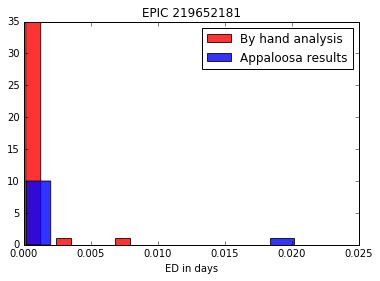

In [5]:

plt.figure()
plt.title('EPIC '+objectid)
plt.hist(myED,len(myED)//5,alpha=0.8,color='red',label='By hand analysis')
plt.hist(AppaED,len(AppaED)//1,alpha=0.8,label='Appaloosa results')
plt.legend()
plt.xlabel('ED in days')
plt.show()
#plt.savefig('results/'+objectid+'_byhand_vs_Appaloosa.png')